
# Árvore de Decisão — Seleção de Analista Financeiro

Notebook educativo preparado para o curso **Introdução ao Machine Learning com Python (UNIVALI)**.

**Objetivo:** Treinar um classificador de **Árvore de Decisão** para **selecionar candidatos** a uma vaga de **Analista Financeiro**,
mostrando **impureza (Gini/Entropia)**, **ganho de informação**, **visualização da árvore** e **métricas de avaliação**.

> O notebook **lê um CSV** com candidatos e conduz o processo de ponta a ponta.


In [1]:
# %% [setup] Importações e Configuração

# Bibliotecas fundamentais para análise de dados e visualização
import pandas as pd              # Para manipulação e análise de dados estruturados
import numpy as np              # Para computação numérica e arrays
import matplotlib.pyplot as plt  # Para criação de gráficos e visualizações

# Importações do scikit-learn para machine learning
# Função para dividir dados em conjuntos de treino e teste
from sklearn.model_selection import train_test_split
# Transformador para converter variáveis categóricas em numéricas
from sklearn.preprocessing import OneHotEncoder
# Para combinar diferentes transformadores em um pipeline
from sklearn.compose import ColumnTransformer
# Para criar pipelines de processamento e modelo
from sklearn.pipeline import Pipeline
# Métricas de avaliação para modelos de classificação
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
# Algoritmo de árvore de decisão e função para visualização
from sklearn.tree import DecisionTreeClassifier, plot_tree
# import da biblioteca os para verificar caminho
import os  

np.random.seed(42)                        # Define uma semente para reprodutibilidade dos resultados aleatórios

In [2]:
csv_path = r"../Datasets/candidatos_financeiro.csv"  # caminho do arquivo CSV

df = pd.read_csv(csv_path)  # carrega o CSV em um DataFrame pandas
print("Dimensões:", df.shape)  # imprime número de linhas e colunas
df.head()  # mostra as primeiras linhas do DataFrame para inspeção

Dimensões: (160, 10)


,experiencia_anos,certificacao_financeira,ingles,excel_avancado,formacao,raciocinio_logico,salario_pretendido,comunicacao,disponibilidade_imediata,selecionado
0,5.6,0,Básico,0,Contabilidade,51.0,5860.0,5.0,1,0
1,4.2,1,Básico,0,Engenharia,89.0,6520.0,3.0,0,0
2,5.9,0,Básico,0,Administração,83.0,6270.0,4.0,0,0
3,7.9,1,Básico,1,Engenharia,70.0,5470.0,4.0,1,1
4,4.0,0,Avançado,1,Contabilidade,74.0,4960.0,4.0,1,1



## 1. Entendendo os dados
Analisamos a distribuição das variáveis e a taxa de aprovação (`selecionado`).

**Análise rápida do arquivo carregado:**
- Verifique se as dimensões e as colunas batem com o esperado.
- Confirme a presença da coluna `selecionado` (target).
- Observe valores ausentes, tipos de colunas e algumas linhas iniciais para checar formatação.

In [3]:
# Exibe um resumo estatístico completo do DataFrame
# include='all' garante que todas as colunas (numéricas e categóricas) sejam consideradas
display(df.describe(include='all'))

tx = df['selecionado'].mean()
# Imprime a taxa formatada como porcentagem com duas casas decimais
print(f"Taxa de candidatos selecionados: {tx:.2%}")

# Observação: verifique colunas com contagem baixa ou valores estranhos que podem afetar os modelos

,experiencia_anos,certificacao_financeira,ingles,excel_avancado,formacao,raciocinio_logico,salario_pretendido,comunicacao,disponibilidade_imediata,selecionado
count,160.000000,160.000000,160,160.000000,160,160.000000,160.000000,160.000000,160.000000,160.000000
unique,NaN,NaN,3,NaN,4,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Básico,NaN,Administração,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,66,NaN,48,NaN,NaN,NaN,NaN,NaN
mean,4.359375,0.537500,NaN,0.425000,NaN,70.887500,5352.562500,3.556250,0.525000,0.381250
std,2.036809,0.500157,NaN,0.495895,NaN,12.289991,959.466733,0.916288,0.500943,0.487219
min,0.000000,0.000000,NaN,0.000000,NaN,39.000000,3010.000000,1.000000,0.000000,0.000000
25%,3.000000,0.000000,NaN,0.000000,NaN,64.000000,4677.500000,3.000000,0.000000,0.000000
50%,4.400000,1.000000,NaN,0.000000,NaN,70.500000,5355.000000,4.000000,1.000000,0.000000
75%,5.525000,1.000000,NaN,1.000000,NaN,79.000000,5980.000000,4.000000,1.000000,1.000000


Taxa de candidatos selecionados: 38.12%


In [4]:
# Define as variáveis numéricas que serão visualizadas em histogramas
cols_num = ['experiencia_anos','raciocinio_logico','salario_pretendido','comunicacao']

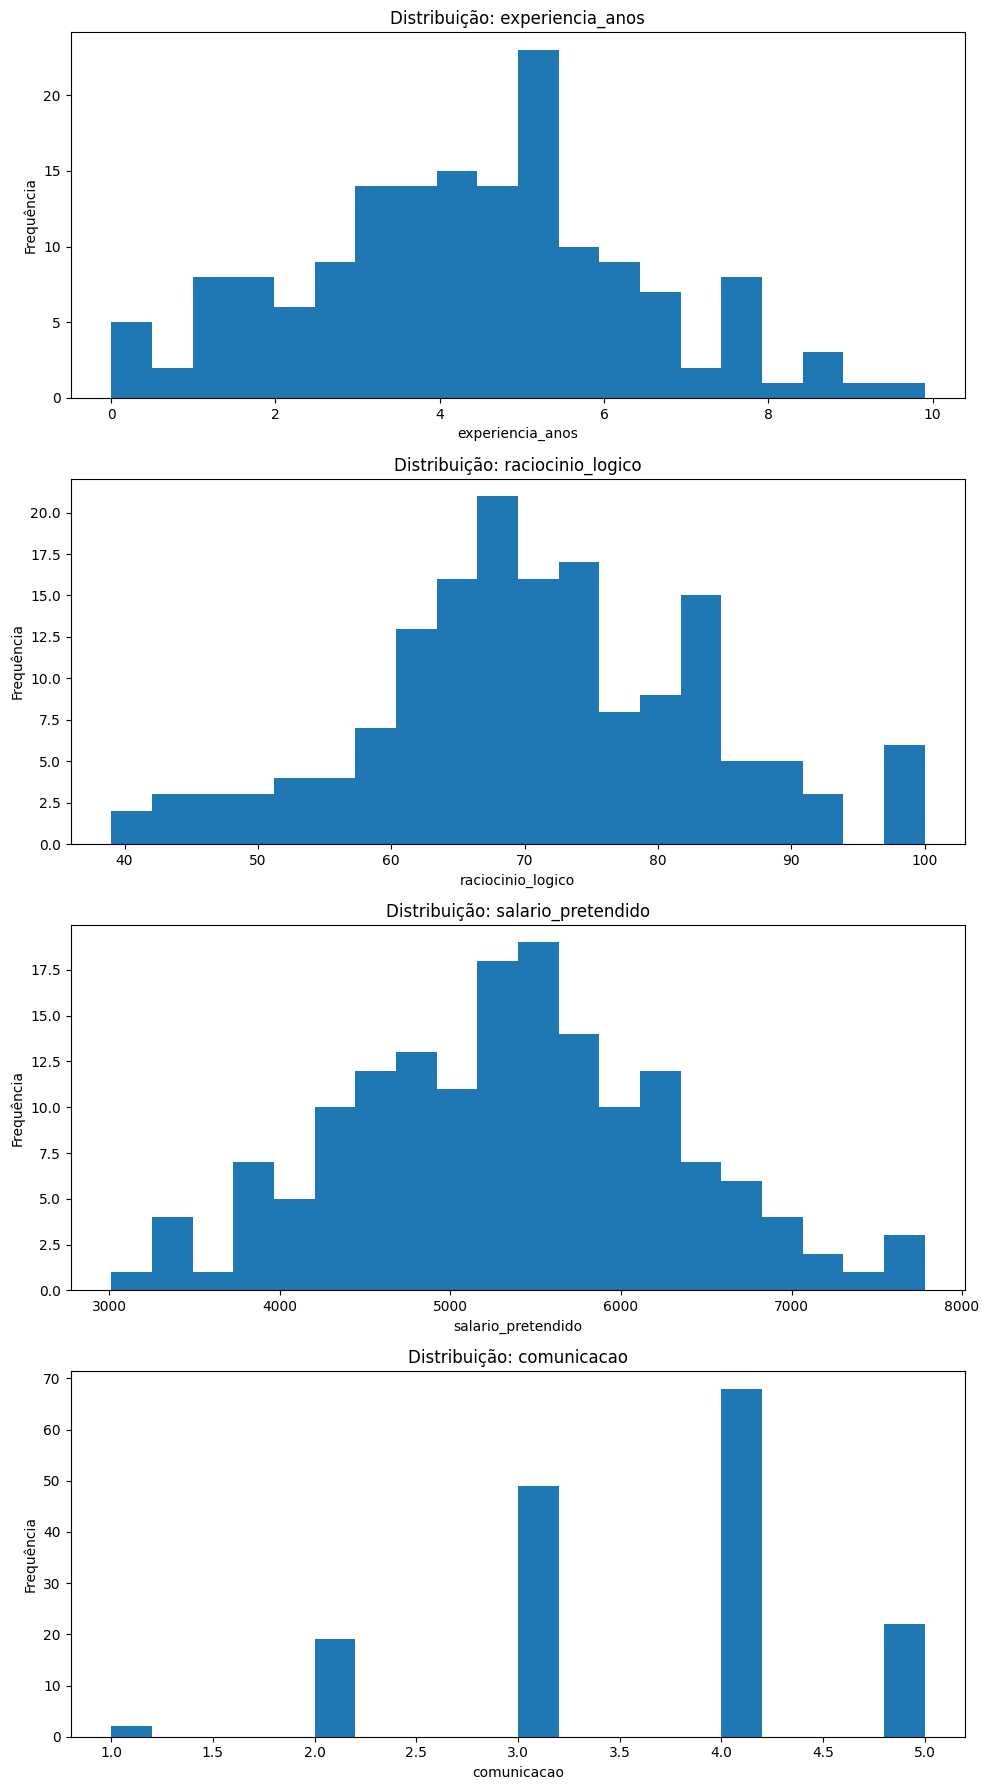

In [5]:
# Cria uma figura com subplots verticais (um para cada variável)
fig, axes = plt.subplots(len(cols_num), 1, figsize=(10, 18))

# Itera sobre os eixos e colunas simultaneamente usando zip
for ax, c in zip(axes, cols_num):
    # Cria um histograma para cada variável usando dados do DataFrame
    ax.hist(df[c].dropna(), bins=20)  # remove NaNs para não quebrar o histograma
    # Adiciona um título descritivo para cada histograma
    ax.set_title(f"Distribuição: {c}")
    # Adiciona rótulos aos eixos para clareza
    ax.set_xlabel(c)
    ax.set_ylabel('Frequência')

# Ajusta layout para evitar sobreposição
plt.tight_layout()
# Mostra o gráfico
plt.show()

# Observação: Histogramas ajudam a detectar assimetria e outliers

**Breve análise do resumo estatístico:**
- A tabela `describe()` mostra contagens, média, desvio padrão e quartis para numéricos; para categóricos mostra contagem e top.
- Procure por outliers em `raciocinio logico` ou contagens muito baixas em categorias.



## 2. Impureza e Ganho de Informação (teoria + prática)

Para classificação binária, as medidas de impureza mais comuns são:

- **Gini:** \( Gini(S) = 1 - p^2 - (1-p)^2 \)
- **Entropia:** \( H(S) = -p \log_2 p - (1-p) \log_2 (1-p) \)

O **Ganho de Informação** de um split X é:

\[ IG(S, X) = I(S) - \sum_{v \in splits} \frac{|S_v|}{|S|}\, I(S_v) \]

onde \(I\) pode ser **Gini** ou **Entropia**.

A seguir, calculamos **na mão** a impureza do conjunto e testamos **splits candidatos**
para uma única feature numérica (`experiencia_anos`) e uma categórica (`ingles`), obtendo o **melhor split** e seu ganho.


**Análise rápida dos histogramas:**
- Verifique se as distribuições são próximas de normal ou fortemente assimétricas.
- Variáveis com baixa variação talvez não ajudem o modelo (podem ser removidas).

In [6]:
# Funções auxiliares para cálculo de impureza e ganho de informação

# Função para calcular o índice de Gini
def gini(y):
    # Recebe uma série/array de rótulos (0/1)
    p = y.mean()  # Calcula a proporção de rótulos positivos
    # Calcula e retorna o índice de Gini: 1 - (p^2 + (1-p)^2)
    return 1 - (p**2 + (1-p)**2)

# Função para calcular a Entropia
def entropy(y):
    # Recebe uma série/array de rótulos (0/1)
    p = y.mean()  # Calcula a proporção de rótulos positivos
    # Se não há diversidade de classes, entropia é zero
    if p == 0 or p == 1:
        return 0.0
    # Calcula e retorna a entropia: -p*log2(p) - (1-p)*log2(1-p)
    return -(p * np.log2(p) + (1 - p) * np.log2(1 - p))


# Função para calcular ganho de informação entre um pai e dois filhos
def info_gain(y, y_left, y_right, impurity_fn):
    # n: tamanho do nó pai
    n = len(y)
    # Se algum filho estiver vazio, não consideramos esse split (ganho indefinido)
    if len(y_left) == 0 or len(y_right) == 0:
        return -np.inf
    # Impureza do nó pai
    pai = impurity_fn(y)
    # Impureza ponderada dos nós filhos
    filho = (len(y_left) / n) * impurity_fn(y_left) + (len(y_right) / n) * impurity_fn(y_right)
    # Retorna o ganho de informação (redução da impureza)
    return pai - filho


# Função para encontrar o melhor split em uma feature numérica
def melhor_split_numerica(x: pd.Series, y: pd.Series, criterio="gini"):
    # Seleciona a função de impureza (gini ou entropia)
    imp = gini if criterio == "gini" else entropy

    # Gera candidatos de corte como médias entre valores consecutivos distintos
    xs = np.sort(x.astype(float).unique())  # Valores únicos ordenados
    # Se não há ao menos dois valores distintos, não há split possível
    if len(xs) < 2:
        return None  # sem split possível

    # Calcula thresholds como pontos médios entre valores adjacentes
    thresholds = (xs[:-1] + xs[1:]) / 2.0
    resultados = []  # lista para armazenar (threshold, gain, n_left, n_right)
    for t in thresholds:
        yL = y[x <= t]  # rótulos do lado esquerdo do split
        yR = y[x > t]   # rótulos do lado direito do split
        gain = info_gain(y, yL, yR, imp)  # calcula ganho para esse threshold
        resultados.append((t, float(gain), len(yL), len(yR)))  # armazena resultado

    # Seleciona o threshold com maior ganho
    t, gain, nL, nR = max(resultados, key=lambda r: r[1])
    # Retorna um dicionário com detalhes do melhor split
    return {"feature": x.name, "threshold": float(t), "gain": gain, "n_left": nL, "n_right": nR, "criterion": criterio}


# Função para encontrar o melhor split em uma feature categórica (one-vs-rest)
def melhor_split_categorica(x: pd.Series, y: pd.Series, criterio="gini"):
    # Seleciona a função de impureza (gini ou entropia)
    imp = gini if criterio == "gini" else entropy
    # Obtém as categorias únicas da feature
    cats = pd.Series(x).astype("category").cat.categories
    # Se há menos de 2 categorias, não é possível dividir
    if len(cats) < 2:
        return None

    resultados = []  # lista para armazenar (categoria, gain, n_left, n_right)
    for c in cats:
        yL = y[x == c]  # rótulos do grupo onde a categoria == c
        yR = y[x != c]  # rótulos do grupo de todas as outras categorias
        gain = info_gain(y, yL, yR, imp)  # calcula ganho para este one-vs-rest
        resultados.append((c, float(gain), len(yL), len(yR)))  # armazena resultado

    # Seleciona a categoria com maior ganho
    c, gain, nL, nR = max(resultados, key=lambda r: r[1])
    # Retorna um dicionário com detalhes do melhor split categórico
    return {"feature": x.name, "category_left": c, "gain": gain, "n_left": nL, "n_right": nR, "criterion": criterio}

# n_left condição verdadeira x <= t
# n_right condição falsa x > t


In [7]:
df_teste = pd.DataFrame({
     "experiencia_anos": [0.5, 1.0, 2.0, 4.6, 5.6, 7.2, 9.0],
     "ingles": ["Básico","Intermediário","Básico","Avançado","Básico","Avançado","Intermediário"],
     "selecionado": [0,0,0,1,0,1,1]
 })
y = df_teste["selecionado"].astype(int)
print(melhor_split_numerica(df_teste["experiencia_anos"], y, "gini"))
print(melhor_split_numerica(df_teste["experiencia_anos"], y, "entropy"))
print(melhor_split_categorica(df_teste["ingles"], y, "gini"))
print(melhor_split_categorica(df["ingles"], y, "entropy"))

{'feature': 'experiencia_anos', 'threshold': 3.3, 'gain': 0.27551020408163274, 'n_left': 3, 'n_right': 4, 'criterion': 'gini'}
{'feature': 'experiencia_anos', 'threshold': 3.3, 'gain': 0.5216406363433185, 'n_left': 3, 'n_right': 4, 'criterion': 'entropy'}
{'feature': 'ingles', 'category_left': 'Básico', 'gain': 0.27551020408163274, 'n_left': 3, 'n_right': 4, 'criterion': 'gini'}
{'feature': 'ingles', 'category_left': 'Intermediário', 'gain': 0.19811742113040343, 'n_left': 1, 'n_right': 6, 'criterion': 'entropy'}



## 3. Modelagem — Árvore de Decisão (Scikit-Learn)

- Pré-processamos as variáveis categóricas com **One-Hot Encoding**.
- Treinamos duas árvores: **Gini** e **Entropia**, com `max_depth=4` para manter explicabilidade.
- Avaliamos **acurácia, precisão, recall, F1**, **matriz de confusão** e **ROC-AUC**.



Árvore (Gini)
Acc=0.750 | Prec=0.857 | Rec=0.400 | F1=0.545 | ROC-AUC=0.785
Matriz de confusão:
 [[24  1]
 [ 9  6]]

Árvore (Entropia)
Acc=0.825 | Prec=0.833 | Rec=0.667 | F1=0.741 | ROC-AUC=0.876
Matriz de confusão:
 [[23  2]
 [ 5 10]]


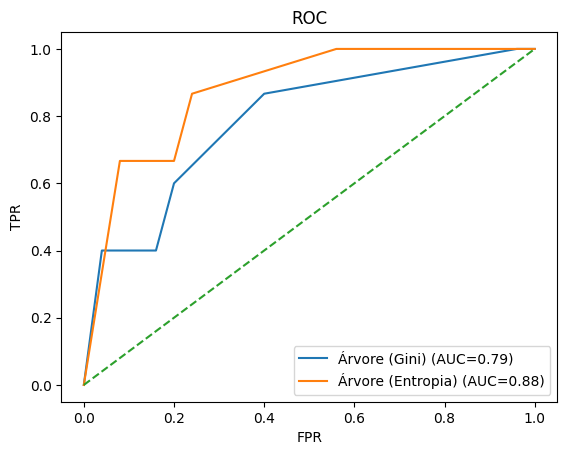

In [8]:
# Separação das features (variáveis independentes) e target (variável dependente)
# Remove a coluna 'selecionado' do DataFrame e armazena todas as outras colunas em X
X = df.drop(columns=['selecionado'])
# Armazena apenas a coluna 'selecionado' em y (nossa variável alvo)
y = df['selecionado']

# Definição das colunas categóricas e numéricas do dataset
# Lista das colunas que contêm dados categóricos
cat_cols = ['ingles','formacao']
# Lista das colunas numéricas (todas as colunas que não estão em cat_cols)
num_cols = [c for c in X.columns if c not in cat_cols]

# Criação do preprocessador para transformar dados categóricos
# ColumnTransformer é usado para aplicar diferentes transformações em diferentes colunas
pre = ColumnTransformer([
    # OneHotEncoder para transformar variáveis categóricas em formato numérico
    # handle_unknown='ignore' permite lidar com categorias não vistas no treino
    # sparse_output=False retorna uma matriz densa ao invés de esparsa
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')  # 'passthrough' mantém as colunas numéricas inalteradas

# Criação de dois modelos de árvore de decisão com diferentes critérios de divisão
# Pipeline combina preprocessamento e modelo em uma única unidade
tree_gini = Pipeline([
    ('pre', pre),  # Primeiro aplica o preprocessamento definido acima
    # Árvore de decisão usando índice Gini como critério de divisão
    ('clf', DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42))
])
tree_ent = Pipeline([
    ('pre', pre),  # Mesmo preprocessamento
    # Árvore de decisão usando entropia como critério de divisão
    ('clf', DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42))
])

# Divisão dos dados em conjuntos de treino e teste
# test_size=0.25 significa que 25% dos dados serão usados para teste
# random_state=42 garante reprodutibilidade
# stratify=y mantém a proporção das classes no conjunto de treino e teste
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Treinamento dos modelos com os dados de treino
tree_gini.fit(X_tr, y_tr)  # Treina o modelo usando critério Gini
tree_ent.fit(X_tr, y_tr)   # Treina o modelo usando critério Entropia

# Função para avaliar o desempenho dos modelos
def eval_model(name, pipe):
    # Faz previsões no conjunto de teste
    y_pred = pipe.predict(X_te)  # Previsões das classes
    y_proba = pipe.predict_proba(X_te)[:,1]  # Probabilidades das previsões (classe positiva)
    
    # Calcula diferentes métricas de avaliação
    acc = accuracy_score(y_te, y_pred)      # Acurácia: proporção de previsões corretas
    prec = precision_score(y_te, y_pred)    # Precisão: proporção de verdadeiros positivos
    rec = recall_score(y_te, y_pred)        # Recall: taxa de detecção de positivos
    f1 = f1_score(y_te, y_pred)            # F1-Score: média harmônica entre precisão e recall
    
    # Calcula pontos para a curva ROC
    fpr, tpr, _ = roc_curve(y_te, y_proba)  # False Positive Rate e True Positive Rate
    roc_auc = auc(fpr, tpr)                 # Área sob a curva ROC
    
    # Imprime as métricas de avaliação
    print(f"\n{name}")
    print(f"Acc={acc:.3f} | Prec={prec:.3f} | Rec={rec:.3f} | F1={f1:.3f} | ROC-AUC={roc_auc:.3f}")
    
    # Calcula e imprime a matriz de confusão
    cm = confusion_matrix(y_te, y_pred)
    print("Matriz de confusão:\n", cm)
    
    # Plota a curva ROC para o modelo atual
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
    return fpr, tpr, roc_auc

# Criação do gráfico para as curvas ROC
plt.figure()  # Cria uma nova figura
# Avalia e plota resultados para ambos os modelos
eval_model("Árvore (Gini)", tree_gini)
eval_model("Árvore (Entropia)", tree_ent)
# Adiciona a linha de referência (random classifier)
plt.plot([0,1],[0,1],'--')
# Configura rótulos e título do gráfico
plt.xlabel("FPR")  # False Positive Rate no eixo X
plt.ylabel("TPR")  # True Positive Rate no eixo Y
plt.title("ROC")   # Título do gráfico
plt.legend()       # Adiciona legenda
plt.show()         # Exibe o gráfico


## 4. Visualizar a árvore treinada

Para visualização simples, extraímos a árvore do pipeline e usamos `plot_tree`.
As **cores** indicam classes, e cada nó mostra a **impureza (gini)**, **amostras** e a **distribuição**.


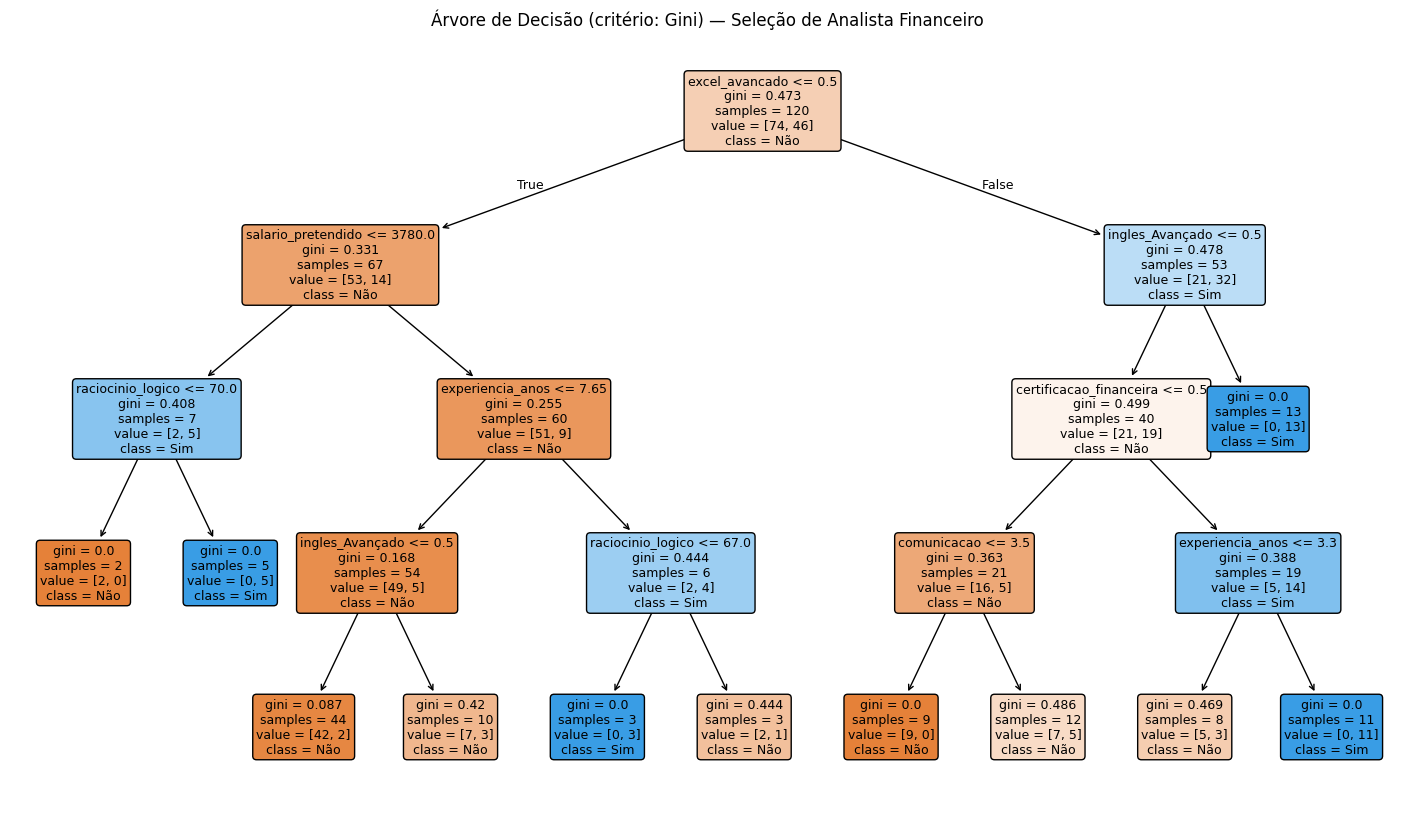

In [9]:

# Extra: visualizar a árvore do modelo Gini
# Cria uma figura grande para visualizar bem a árvore
plt.figure(figsize=(18,10))
# Para plot_tree, precisamos das features após o OneHotEncoder:
Nomes_Features = tree_gini.named_steps['pre'].named_transformers_['onehot'] # extrai o OneHotEncoder do pipeline 
oh_features = list(Nomes_Features.get_feature_names_out(['ingles','formacao'])) # nomes das features após OneHotEncoding
all_features = oh_features + [c for c in X.columns if c not in ['ingles','formacao']] # todas as features finais

clf = tree_gini.named_steps['clf']

plot_tree(clf, feature_names=all_features, class_names=['Não','Sim'], filled=True, rounded=True, fontsize=9)
plt.title("Árvore de Decisão (critério: Gini) — Seleção de Analista Financeiro")
plt.show()


[0 1]


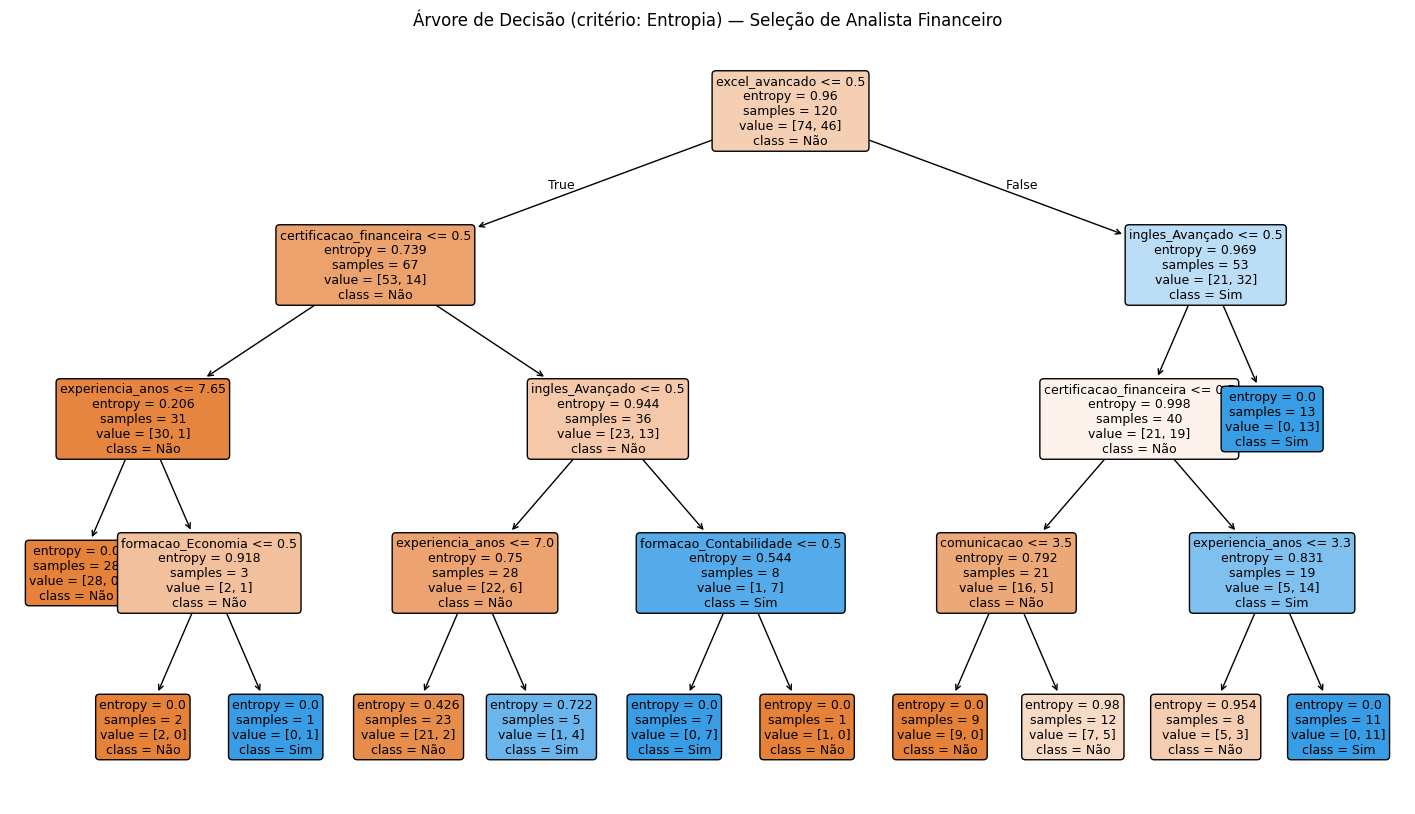

In [10]:
# Extrai o classificador (árvore de decisão) do pipeline
# named_steps['clf'] acessa o componente 'clf' do pipeline
clf = tree_ent.named_steps['clf'] # extrai o classificador do pipeline

# Cria uma figura grande para visualizar bem a árvore
plt.figure(figsize=(18,10))

# Plota a árvore de decisão com várias configurações visuais
# feature_names: nomes das características para mostrar nas decisões
# class_names: nomes das classes para mostrar nas folhas
# filled=True: preenche os nós com cores baseadas na classe majoritária
# rounded=True: usa cantos arredondados nos nós
# fontsize=9: define o tamanho da fonte para legibilidade
plot_tree(clf, feature_names=all_features, class_names=['Não','Sim'], 
          filled=True, rounded=True, fontsize=9)
print(clf.classes_)
# Adiciona um título explicativo ao gráfico
plt.title("Árvore de Decisão (critério: Entropia) — Seleção de Analista Financeiro")

# Exibe o gráfico
plt.show()


## 5. Importância das variáveis

A importância mede a **redução média de impureza** (MDI) causada por cada feature ao longo da árvore.


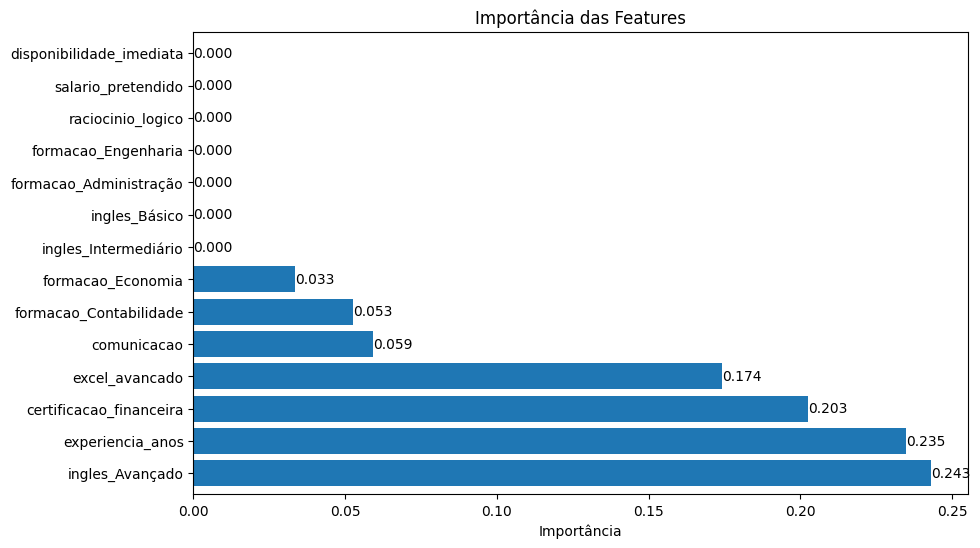

In [11]:
# Obtém as importâncias das características do modelo
# feature_importances_ é um atributo que indica quanto cada feature contribui para as decisões
importances = pd.Series(clf.feature_importances_, index=all_features)

# Ordena as importâncias em ordem decrescente
importances = importances.sort_values(ascending=False)

# Cria um gráfico de barras horizontais para visualizar as importâncias
plt.figure(figsize=(10,6))
# barh cria barras horizontais
# width=0.8 controla a largura das barras
importances.plot(kind='barh', width=0.8)

# Personaliza o gráfico
plt.title("Importância das Features")  # Adiciona título
plt.xlabel("Importância")              # Rótulo do eixo x

# Exibe os valores numéricos ao lado das barras
for i, v in enumerate(importances):
    # Adiciona texto com o valor formatado com 3 casas decimais
    plt.text(v, i, f'{v:.3f}', va='center')

## 🌳 Como ler a Árvore de Decisão

Cada **caixinha** da árvore mostra um grupo de dados e as regras que o modelo aprendeu para separar as classes (por exemplo: **Selecionado** ou **Não selecionado**).

---

### 🧩 Exemplo de nó

```
excel_avancado <= 0.5
entropy = 0.96
samples = 120
value = [74, 46]
class = Não
```

---

### 🧠 O que significa cada linha

| Linha | Significado |
|-------|--------------|
| **excel_avancado <= 0.5** | Regra usada para dividir os dados (quem tem ou não Excel avançado). |
| **entropy = 0.96** | Mede o quanto o grupo está misturado (0 = puro, 1 = muito misturado). |
| **samples = 120** | Quantas pessoas chegaram até esse ponto da árvore. |
| **value = [74, 46]** | Quantas são da classe **Não** e quantas da classe **Sim**. |
| **class = Não** | A classe mais comum nesse grupo (o que o modelo prevê). |

---

### 🍃 Folhas

As **folhas** são os nós finais — onde o modelo **para de dividir** e **dá uma resposta**.

Exemplo:
```
samples = 13
value = [0, 13]
class = Sim
```
➡️ Todos são da classe **Sim**, então o modelo prevê **Sim** para quem cair aqui.

---

### ⚙️ Em resumo

- **Nós internos:** fazem perguntas (divisões).  
- **Folhas:** mostram a decisão final.  
- **Menor entropia ou gini = grupo mais puro.**  
- **Classe = resposta que o modelo dará.**



## 6. Simular a triagem de novos candidatos

Monte um dicionário com os dados do candidato e verifique a previsão.


In [12]:
# ---------- 1) Candidato de teste ----------
candidate_full = {
    "experiencia_anos": 4,
    "certificacao_financeira": 1,
    "ingles": "Intermediário",
    "excel_avancado": 0,
    "formacao": "Contabilidade",
    "raciocinio_logico": 8.0,
    "salario_pretendido": 4500.0,
    "comunicacao": 7.5,
    "disponibilidade_imediata": 0
}

novo_candidato = pd.DataFrame([candidate_full])

print("=== Perfil do Candidato ===")
display(novo_candidato)

# ---------- 2) Predição para o candidato ----------
prob = tree_ent.predict_proba(novo_candidato)[0, 1]
pred = tree_ent.predict(novo_candidato)[0]
print(f"Probabilidade de ser selecionado Entropy: {prob:.2%}")
print("Predição final:", "Selecionado" if pred==1 else "Não Selecionado")

prob = tree_gini.predict_proba(novo_candidato)[0, 1]
pred = tree_gini.predict(novo_candidato)[0]
print(f"Probabilidade de ser selecionado GINI: {prob:.2%}")
print("Predição final:", "Selecionado" if pred==1 else "Não Selecionado")

=== Perfil do Candidato ===


,experiencia_anos,certificacao_financeira,ingles,excel_avancado,formacao,raciocinio_logico,salario_pretendido,comunicacao,disponibilidade_imediata
0,4,1,Intermediário,0,Contabilidade,8.0,4500.0,7.5,0


Probabilidade de ser selecionado Entropy: 8.70%
Predição final: Não Selecionado
Probabilidade de ser selecionado GINI: 4.55%
Predição final: Não Selecionado
